In [3]:
import tensorflow as tf
import numpy as np
import importlib
import facenet

from scipy import misc

data_dir = '../datasets/CUHK01'
pretrained_model_file = '../trained/facenet/20161028-190939/model.ckpt-10000'
network = importlib.import_module('models.nn4_small2_reid2', 'inference')

# train_set = facenet.get_dataset(data_dir)

def get_dataset(paths):
    import os
    dataset = []
    for path in paths.split(':'):
        path_exp = os.path.expanduser(path)
        classes = os.listdir(path_exp)
        classes.sort()
        nrof_classes = len(classes)
        for i in range(nrof_classes):
            class_name = classes[i]
            facedir = os.path.join(path_exp, class_name)
            if os.path.isdir(facedir):
                images = os.listdir(facedir)
                image_paths = sorted([os.path.join(facedir,img) for img in images])
                dataset.append(image_paths)
    return dataset
# print(train_set)

dataset = get_dataset(data_dir)

n_classes = len(dataset)
n_total_samples = n_classes * 4

with tf.Graph().as_default():
    with tf.Session() as sess:
        # Load the model
        print('Loading model "%s"' % pretrained_model_file)
        facenet.load_model(pretrained_model_file)
        
        # Get input and output tensors
        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        image_size = images_placeholder.get_shape()
        
        features = np.zeros((n_total_samples, 128))
        for i in xrange(n_classes):
            n_samples = len(dataset[i])
            images = np.zeros((n_samples, image_size[1], image_size[2], image_size[3]))
            for j in xrange(n_samples):
                images[j, :, :, :] = misc.imread(dataset[i][j])
            feed_dict = { images_placeholder:images, phase_train_placeholder:False }
            features[(i*4):((i+1)*4), :] = sess.run(embeddings, feed_dict=feed_dict)

Loading model "../trained/facenet/20161028-190939/model.ckpt-10000"


(3884, 128)


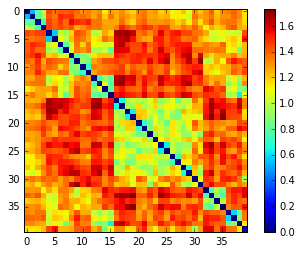

In [4]:
print(features.shape)
import sklearn.metrics.pairwise

dm = sklearn.metrics.pairwise.euclidean_distances(features)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(dm[0:40, 0:40], interpolation='nearest')
plt.colorbar()
plt.show()